## Fitting Scalers and Cleaning the dataset

This notebook has components of both scaling and inverse scaling the dataset for the comparison plotting in ml/torchnn/network.ipynb and in dataset cleaning so that the predictions are better.

##### Scalers section

importing correct packages for scalers

In [ ]:
from astropy.table import Table
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import h5py
import matplotlib.pyplot as plt
from gaiaxpy import generate, PhotometricSystem
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Everything here the same as in ml/torchnn/network.ipynb

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
# # scalers for dataloading
# metscaler = MinMaxScaler()
# logscaler = MinMaxScaler()
# tefscaler = MinMaxScaler()
# scalerlist = [MinMaxScaler() for _ in range(110)] # Hardcoded since we know number of xp coefficients is static

# # dataloader batchlength, learning rate, epochs for training
# batchlen = 32
# lr = 1e-2
# epochs = 100

# class ResBlock(nn.Module):
#     def __init__(self, nodes):
#         super(ResBlock, self).__init__()
#         self.res_block1 = nn.Sequential(
#             nn.Linear(nodes,nodes),
#             nn.BatchNorm1d(nodes),
#             nn.LeakyReLU(),
#         )
#         self.res_block2 = nn.Sequential(
#             nn.Linear(nodes,nodes),
#             nn.BatchNorm1d(nodes),
#         )
#         self.lrelu = nn.LeakyReLU()
    
#     def forward(self, x):
#         res = x
#         x = self.res_block1(x)
#         x = self.res_block2(x)
#         x = x + res
#         output = self.lrelu(x)
#         return output
        
# class ResNetMcK(nn.Module):
#     def __init__(self):
#         super(ResNetMcK, self).__init__()
#         self.input_block = nn.Sequential(
#             nn.Linear(3,16),
#             nn.LeakyReLU(),
#         )
#         self.blocklist = nn.ModuleList([
#             ResBlock(16),
#             ResBlock(16),
#             nn.Linear(16,32),
#             ResBlock(32),
#             ResBlock(32),
#             nn.Linear(32,64),
#             ResBlock(64),
#             ResBlock(64),
#             nn.Linear(64,128),
#             ResBlock(128),
#             ResBlock(128),
#         ])
#         self.output_block = nn.Sequential(
#             nn.Linear(128,110),
#         )
        
#     def forward(self,x):
#         x = self.input_block(x)
#         for i, _ in enumerate(self.blocklist):
#             x = self.blocklist[i](x)
#         logits = self.output_block(x)
#         return logits
    
# # defining the Dataset class
# class train_set(Dataset):
#     def __init__(self,file):
#         fn = h5py.File(file, 'r')
#         self.f = fn
        
#         # get data
#         dset = fn['group_1']['data']
#         self.x = torch.Tensor(dset[:].T)
        
#         # get label
#         ydset = self.f['group_1']['label']
#         self.y = torch.Tensor(ydset[:].T)
#         # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
        
#         # get error in label # comment out for non-error label runs
#         errdset = self.f['group_1']['e_label']
#         self.err = torch.Tensor(errdset[:].T)
        
#     def __len__(self):
#         return self.f['group_1']['data'].shape[1]
  
#     def __getitem__(self, index):
#         xg = self.x[index]
#         yg = self.y[index]
#         errg = self.err[index]
#         return (xg,yg,errg)

# class valid_set(Dataset):
#     def __init__(self,file):
#         fn = h5py.File(file, 'r')
#         self.f = fn
        
#         # get data
#         dset = self.f['group_2']['data']
#         self.x = torch.Tensor(dset[:].T)
        
#         # get label
#         ydset = self.f['group_2']['label']
#         self.y = torch.Tensor(ydset[:].T)
#         # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
        
#         # get error in label # comment out for non-error label runs
#         errdset = self.f['group_2']['e_label']
#         self.err = torch.Tensor(errdset[:].T)
        
#     def __len__(self):
#         return self.f['group_2']['data'].shape[1]
  
#     def __getitem__(self, index):
#         xg = self.x[index]
#         yg = self.y[index]
#         errg = self.err[index]
#         return (xg,yg,errg)
    
# class new_data_set(Dataset):
#     def __init__(self,file,train=True,valid=False):
#         fn = h5py.File(file, 'r')
#         self.f = fn
        
#         # get data
#         dset = fn['group_1']['data']
#         d = dset[:]
#         dat = np.array([
#             metscaler.fit_transform(d[[0]].T).flatten(),
#             logscaler.fit_transform(d[[1]].T).flatten(),
#             tefscaler.fit_transform(d[[2]].T).flatten(),
#         ])
#         if train:
#             self.l = dat.shape[1]
#             self.x = torch.Tensor(dat.T)
#         elif valid:
#             dset = fn['group_2']['data']
#             d = dset[:]
#             dat = np.array([
#                 metscaler.transform(d[[0]].T).flatten(),
#                 logscaler.transform(d[[1]].T).flatten(),
#                 tefscaler.transform(d[[2]].T).flatten(),
#             ])
#             self.l = dat.shape[1]
#             self.x = torch.Tensor(dat.T)
        
#         # get label
#         ydset = self.f['group_1']['label']
#         yd = ydset[:]
#         ydat = np.array([
#             scaler.fit_transform(yd[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
#         ])
#         if train:
#             self.y = torch.Tensor(ydat[:].T) # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
#         elif valid:
#             ydset = self.f['group_2']['label']
#             yd = ydset[:]
#             ydat = np.array([
#                 scaler.transform(yd[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
#             ])
#             self.y = torch.Tensor(ydat[:].T)
        
#         # get error in label # comment out for non-error label runs
#         if train:
#             errdset = self.f['group_1']['e_label']
#             self.err = torch.Tensor(errdset[:].T)
#         elif valid:
#             errdset = self.f['group_2']['e_label']
#             self.err = torch.Tensor(errdset[:].T)
        
#     def __len__(self):
#         return self.l
  
#     def __getitem__(self, index):
#         xg = self.x[index]
#         yg = self.y[index]
#         errg = self.err[index]
#         return (xg,yg,errg)

In [ ]:
# scalers for dataloading
metscaler = MinMaxScaler()
logscaler = MinMaxScaler()
tefscaler = MinMaxScaler()
amscaler = MinMaxScaler()
scalerlist = [MinMaxScaler() for _ in range(110)] # Hardcoded since we know number of xp coefficients is static

scale = 'MinMax'
batchlen = 32
lr = 1e-2
epochs = 2
optimize = 'SGD'
datafname = '/arc/home/aydanmckay/input_catalogue_simple_average_datacuts.h5'
lossname = 'L2'
# datafname = '/arc/home/aydanmckay/input_catalogue_datacuts.h5'

In [ ]:
class new_data_set(Dataset):
    def __init__(self,file,train=True,valid=False,test=False,noscale=False):
        fn = h5py.File(file, 'r')
        self.f = fn
        
        # get data
        dset = fn['group_1']['data']
        d = dset[:]
        dat = np.array([
            metscaler.fit_transform(d[[0]].T).flatten(),
            logscaler.fit_transform(d[[1]].T).flatten(),
            tefscaler.fit_transform(d[[2]].T).flatten(),
            # amscaler.fit_transform(d[[3]].T).flatten(), # comment out if not
        ])
        if train:
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
        elif valid:
            dset = fn['group_2']['data']
            d = dset[:]
            dat = np.array([
                metscaler.transform(d[[0]].T).flatten(),
                logscaler.transform(d[[1]].T).flatten(),
                tefscaler.transform(d[[2]].T).flatten(),
                # amscaler.transform(d[[3]].T).flatten(), # comment out if not
            ])
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
        elif test:
            dset = fn['group_3']['data']
            d = dset[:]
            dat = np.array([
                metscaler.transform(d[[0]].T).flatten(),
                logscaler.transform(d[[1]].T).flatten(),
                tefscaler.transform(d[[2]].T).flatten(),
                # amscaler.transform(d[[3]].T).flatten(), # comment out if not
            ])
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
            self.x = dat.T
        elif noscale:
            dset = fn['group_3']['data']
            d = dset[:]
            self.l = d.shape[1]
            self.x = torch.Tensor(d.T)
            self.x = d.T
        
        # get label
        ydset = self.f['group_1']['label']
        yd = ydset[:]
        ydat = np.array([
            scaler.fit_transform(yd[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
        ])
        if train:
            self.y = torch.Tensor(ydat[:].T) # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
        elif valid:
            ydset = self.f['group_2']['label']
            yd = ydset[:]
            ydat = np.array([
                scaler.transform(yd[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
            ])
            self.y = torch.Tensor(ydat[:].T)
        elif test:
            ydset = self.f['group_3']['label']
            yd = ydset[:]
            ydat = np.array([
                scaler.transform(yd[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
            ])
            self.y = torch.Tensor(ydat[:].T)
        elif noscale:
            ydset = self.f['group_3']['label']
            yd = ydset[:]
            self.y = torch.Tensor(yd.T)
        
        # get error in label # comment out for non-error label runs
        if train:
            errdset = self.f['group_1']['e_label']
            self.err = torch.Tensor(errdset[:].T)
        elif valid:
            errdset = self.f['group_2']['e_label']
            self.err = torch.Tensor(errdset[:].T)
        elif test or noscale:
            errdset = self.f['group_3']['e_label']
            self.err = torch.Tensor(errdset[:].T)
        
    def __len__(self):
        return self.l
  
    def __getitem__(self, index):
        xg = self.x[index]
        yg = self.y[index]
        errg = self.err[index]
        return (xg,yg,errg)
    
class ResBlock(nn.Module):
    def __init__(self, nodes):
        super(ResBlock, self).__init__()
        self.res_block1 = nn.Sequential(
            nn.Linear(nodes,nodes),
            nn.BatchNorm1d(nodes),
            nn.LeakyReLU(),
        )
        self.res_block2 = nn.Sequential(
            nn.Linear(nodes,nodes),
            nn.BatchNorm1d(nodes),
        )
        self.lrelu = nn.LeakyReLU()
#         add dropout in the init
        self.do = nn.Dropout() #
    
    def forward(self, x):
        res = x
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = x + res
        output = self.lrelu(x)
#         add dropout after the relu
        output = self.do(x) #
        return output
        
class ResNetMcK(nn.Module):
    def __init__(self):
        super(ResNetMcK, self).__init__()
        self.input_block = nn.Sequential(
            nn.Linear(3,16),
            nn.LeakyReLU(),
        )
        self.blocklist = nn.ModuleList([
            ResBlock(16),
            ResBlock(16),
            nn.Linear(16,32),
            ResBlock(32),
            ResBlock(32),
            nn.Linear(32,64),
            ResBlock(64),
            ResBlock(64),
            nn.Linear(64,128),
            ResBlock(128),
            ResBlock(128),
        ])
        self.output_block = nn.Sequential(
            nn.Linear(128,110),
        )
        
    def forward(self,x):
        x = self.input_block(x)
        for i, _ in enumerate(self.blocklist):
            x = self.blocklist[i](x)
        logits = self.output_block(x)
        return logits

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 110),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

# try 3-layer simple network with sigmoid

In [ ]:
# # training_data = train_set("/arc/home/aydanmckay/mydataelabelssmallscalecuts.h5")
# # data = valid_set("/arc/home/aydanmckay/smallcutdataMinMaxscaled.h5")
# # training_data = new_data_set('/arc/home/aydanmckay/smallcutdata.h5',train=True,valid=False)
# valid_data = new_data_set('/arc/home/aydanmckay/smallcutdata.h5',train=False,valid=True)
# loaded_data = DataLoader(
#     valid_data,
#     batch_size=32,
#     num_workers=0
#     # shuffle=True
# )

In [ ]:
test_data = new_data_set(datafname,train=False,test=True)
loaded_data = DataLoader(
    test_data,
    batch_size=batchlen,
    # shuffle=True,
    num_workers=0
)
unscaled_data = new_data_set(datafname,train=False,noscale=True)
unscaled_dataloader = DataLoader(
    unscaled_data,
    batch_size=batchlen,
    # shuffle=True,
    num_workers=0
)

In [ ]:
scales = []
noscales = []
with torch.no_grad():
    for (X, y, z), (X2, y2, z2) in zip(loaded_data,unscaled_data):
        for scaled,noscaled in zip(y,y2):
            # print(scaled)
            scales.append(scaled)
            noscales.append(noscaled)

In [ ]:
len(noscales)

In [ ]:
np.shape(scales)

In [ ]:
model = ResNetMcK()
model.load_state_dict(torch.load("/arc/home/aydanmckay/torchresmodel/modelL2smallminmaxscalecutsbl32lr-2wd-5SGDep100new.pth"))
# model.eval()

In [ ]:
model = model.to(device)

Checking to see if I can put the covariance matrix in the correct form for the gaiaxpy tool/

In [ ]:
preds = []
covbs = []
covrs = []
with torch.no_grad():
    for X, y, z in loaded_data:
        X = X.to(device)
        y = y.to(device)
        z = z.to(device)
        pred = model(X)
        for prediction,err in zip(pred,z):
            covbp = np.zeros((55,55))
            covrp = np.zeros((55,55))
            preds.append(prediction)
            for it in range(len(err[:55])):
                covbp[it][it] += err[it].item()**2
                covrp[it][it] += err[it+55].item()**2
            covbs.append(covbp)
            covrs.append(covrp)

In [ ]:
np.array(covrs).shape

(5000, 55, 55)

In [ ]:
# phot_system_list = [
#     PhotometricSystem.Gaia_2,
#     PhotometricSystem.Gaia_DR3_Vega,
#     PhotometricSystem.PanSTARRS1,
#     PhotometricSystem.PanSTARRS1_Std,
#     PhotometricSystem.Pristine,
#     PhotometricSystem.SDSS,
#     PhotometricSystem.SDSS_Std
# ]

In [ ]:
# df = pd.DataFrame(
#     {'source_id':range(len(preds)),
#      'bp_coefficients':[pred.to('cpu').numpy()[:55] for pred in preds],
#      'bp_standard_deviation':[np.std(pred.to('cpu').numpy()[:55]) for pred in preds],
#      'bp_coefficient_covariances':covbs,
#      'rp_coefficients':[pred.to('cpu').numpy()[55:] for pred in preds],
#      'rp_coefficient_covariances':covrs,
#      'rp_standard_deviation':[np.std(pred.to('cpu').numpy()[55:]) for pred in preds]
#     }
# )

trying out the Gaiaxpy tool

In [ ]:
# df

In [ ]:
f = "select TOP 1 source_id from gaiadr3.gaia_source where source_id = '4486317061229025280'"

In [ ]:
synthetic_photometry = generate(f, photometric_system=PhotometricSystem.Pristine)
# synthetic_photometry = generate(df, photometric_system=PhotometricSystem.Pristine)
# synthetic_photometry

In [ ]:
synthetic_photometry

In [ ]:
# PhotometricSystem.get_available_systems()

continuing on to getting all the data in the right format

In [ ]:
preds = np.array([pred.to('cpu').numpy() for pred in preds]).T

In [ ]:
preds.shape

(110, 5000)

In [ ]:
# rpnewpred = []
xpnewpred = []
for pred,scaler in zip(preds,scalerlist):
    xpnewpred.append(scaler.inverse_transform(np.array([pred]).T).flatten())

In [ ]:
bpnews = np.array(xpnewpred[:55]).T
rpnews = np.array(xpnewpred[55:]).T
rpnews.shape

(5000, 55)

In [ ]:
bpnews.shape

(5000, 55)

In [ ]:
len(preds.T)

5000

In [ ]:
dfnew = pd.DataFrame(
    {'source_id':range(len(preds.T)),
     'bp_coefficients':list(bpnews),
     'bp_standard_deviation':[np.std(bp) for bp in bpnews],
     'bp_coefficient_covariances':covbs,
     'rp_coefficients':list(rpnews),
     'rp_coefficient_covariances':covrs,
     'rp_standard_deviation':[np.std(rp) for rp in rpnews]
    }
)

In [ ]:
dfnew

In [ ]:
synthetic_photometry = generate(dfnew, photometric_system=PhotometricSystem.Pristine)
synthetic_photometry

In [ ]:
synthetic_photometry.describe()

In [ ]:
# max(synthetic_pho)

Looks like it worked out and the dataframe created was in the correct format for the tool. Now this is employed in the /ml/torchnn/network.ipynb notebook.

## Cleaning the Dataset

When predicting the labels, there's still a huge amount of scatter. So here we're gonna see if we can clean the data set more.

In [1]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import h5py
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [13]:
data = Table.read('/arc/home/aydanmckay/input_catalogue_simple_average_datacuts.fits').to_pandas()

In [14]:
data.shape

(6756683, 224)

In [15]:
data.describe()

,Source,Teff,Fe/H,log_g,bp_1,bp_2,bp_3,bp_4,bp_5,bp_6,...,rpe_46,rpe_47,rpe_48,rpe_49,rpe_50,rpe_51,rpe_52,rpe_53,rpe_54,rpe_55
count,6.756683e+06,3.187680e+06,6.751570e+06,3.187576e+06,6.756683e+06,6.756683e+06,6.756683e+06,6.756683e+06,6.756683e+06,6.756683e+06,...,6.756683e+06,6.756683e+06,6.756683e+06,6.756683e+06,6.756683e+06,6.756683e+06,6.756683e+06,6.756683e+06,6.756683e+06,6.756683e+06
mean,1.999936e+18,5.576873e+03,-4.927676e-01,3.895047e+00,5.841186e+03,-7.438423e+02,-3.719608e+01,2.165357e+01,-2.307720e+01,-1.566138e+01,...,9.047463e-01,7.399703e-01,7.294618e-01,6.771119e-01,6.845269e-01,5.994575e-01,5.308829e-01,4.788270e-01,2.005341e-01,1.092285e-01
std,1.826684e+18,9.254797e+02,4.697559e-01,8.280741e-01,7.974963e+04,1.728082e+04,5.147502e+03,3.015247e+03,1.061965e+03,6.643736e+02,...,1.494633e+01,1.259323e+01,1.203212e+01,1.173940e+01,1.111587e+01,9.783625e+00,8.978025e+00,8.014163e+00,2.874799e+00,1.915990e+00
min,3.865554e+10,2.000061e+03,-4.487347e+00,1.022424e-01,-4.954706e-01,-2.105524e+07,-1.199590e+06,-3.189713e+06,-2.969930e+05,-6.277550e+05,...,7.365149e-02,7.316706e-02,5.036612e-02,5.157712e-02,5.979707e-02,4.621989e-02,4.440006e-02,4.108531e-02,2.037394e-02,1.122545e-02
25%,6.572730e+17,4.925000e+03,-6.730000e-01,3.666942e+00,4.617925e+02,-3.020744e+02,-3.576987e+01,6.949978e-01,-1.453489e+01,-7.338217e+00,...,2.493492e-01,2.075408e-01,1.927434e-01,1.810689e-01,1.894968e-01,1.578254e-01,1.404493e-01,1.274166e-01,6.137829e-02,3.367546e-02
50%,1.287940e+18,5.551740e+03,-4.210000e-01,4.151914e+00,1.040309e+03,-9.662795e+01,-8.412148e+00,4.494834e+00,-4.759689e+00,-1.403381e+00,...,3.456380e-01,2.857408e-01,2.878978e-01,2.641425e-01,2.655730e-01,2.330363e-01,2.004483e-01,1.800776e-01,7.973541e-02,4.240140e-02
75%,2.990162e+18,6.003603e+03,-2.037373e-01,4.444950e+00,3.029500e+03,-4.014120e+01,8.946567e-01,1.459134e+01,-1.736392e+00,1.439386e+00,...,5.756168e-01,4.717037e-01,5.016491e-01,4.543718e-01,4.443582e-01,4.042360e-01,3.393861e-01,3.026419e-01,1.212455e-01,6.185629e-02
max,6.917529e+18,2.968421e+04,4.591588e+00,5.990000e+00,5.012911e+07,1.347105e+06,6.696551e+06,3.933293e+06,1.205107e+06,4.104831e+05,...,2.374081e+04,2.328102e+04,2.089838e+04,2.083271e+04,1.827534e+04,1.626270e+04,1.637389e+04,1.400538e+04,4.069050e+03,2.273601e+03


for some reason there is a huge descrpancy in Teff and logg....

In [5]:
with pd.option_context('mode.use_inf_as_na', True):
    data.dropna(inplace=True)
data.shape

(3185660, 224)

removing the coefficient labels with a very large uncertainty

In [6]:
labels = ["bp_1", "bp_2", "bp_3", "bp_4", "bp_5", "bp_6", "bp_7",
          "bp_8", "bp_9", "bp_10", "bp_11", "bp_12", "bp_13", "bp_14",
          "bp_15", "bp_16", "bp_17", "bp_18", "bp_19", "bp_20", "bp_21",
          "bp_22", "bp_23", "bp_24", "bp_25", "bp_26", "bp_27", "bp_28",
          "bp_29", "bp_30", "bp_31", "bp_32", "bp_33", "bp_34", "bp_35",
          "bp_36", "bp_37", "bp_38", "bp_39", "bp_40", "bp_41", "bp_42",
          "bp_43", "bp_44", "bp_45", "bp_46", "bp_47", "bp_48", "bp_49",
          "bp_50", "bp_51", "bp_52", "bp_53", "bp_54", "bp_55", "rp_1",
          "rp_2", "rp_3", "rp_4", "rp_5", "rp_6", "rp_7", "rp_8",
          "rp_9", "rp_10", "rp_11", "rp_12", "rp_13", "rp_14", "rp_15",
          "rp_16", "rp_17", "rp_18", "rp_19", "rp_20", "rp_21", "rp_22",
          "rp_23", "rp_24", "rp_25", "rp_26", "rp_27", "rp_28", "rp_29",
          "rp_30", "rp_31", "rp_32", "rp_33", "rp_34", "rp_35", "rp_36",
          "rp_37", "rp_38", "rp_39", "rp_40", "rp_41", "rp_42", "rp_43",
          "rp_44", "rp_45", "rp_46", "rp_47", "rp_48", "rp_49", "rp_50",
          "rp_51", "rp_52", "rp_53", "rp_54", "rp_55"]
elabels = ["bpe_1", "bpe_2", "bpe_3", "bpe_4", "bpe_5", "bpe_6", "bpe_7",
          "bpe_8", "bpe_9", "bpe_10", "bpe_11", "bpe_12", "bpe_13", "bpe_14",
          "bpe_15", "bpe_16", "bpe_17", "bpe_18", "bpe_19", "bpe_20", "bpe_21",
          "bpe_22", "bpe_23", "bpe_24", "bpe_25", "bpe_26", "bpe_27", "bpe_28",
          "bpe_29", "bpe_30", "bpe_31", "bpe_32", "bpe_33", "bpe_34", "bpe_35",
          "bpe_36", "bpe_37", "bpe_38", "bpe_39", "bpe_40", "bpe_41", "bpe_42",
          "bpe_43", "bpe_44", "bpe_45", "bpe_46", "bpe_47", "bpe_48", "bpe_49",
          "bpe_50", "bpe_51", "bpe_52", "bpe_53", "bpe_54", "bpe_55", "rpe_1",
          "rpe_2", "rpe_3", "rpe_4", "rpe_5", "rpe_6", "rpe_7", "rpe_8",
          "rpe_9", "rpe_10", "rpe_11", "rpe_12", "rpe_13", "rpe_14", "rpe_15",
          "rpe_16", "rpe_17", "rpe_18", "rpe_19", "rpe_20", "rpe_21", "rpe_22",
          "rpe_23", "rpe_24", "rpe_25", "rpe_26", "rpe_27", "rpe_28", "rpe_29",
          "rpe_30", "rpe_31", "rpe_32", "rpe_33", "rpe_34", "rpe_35", "rpe_36",
          "rpe_37", "rpe_38", "rpe_39", "rpe_40", "rpe_41", "rpe_42", "rpe_43",
          "rpe_44", "rpe_45", "rpe_46", "rpe_47", "rpe_48", "rpe_49", "rpe_50",
          "rpe_51", "rpe_52", "rpe_53", "rpe_54", "rpe_55"]

In [7]:
for label in elabels:
    data = data[(data[label] < 10) & (data[label] > -10)]
data.shape

(2760468, 224)

In [ ]:
data.describe()

Plotting the data to see what we're working with.

In [ ]:
plt.hist(data['Teff'],bins=50,log=True);
plt.xlabel('Teff');

In [ ]:
plt.hist(data['Fe/H'][data['Fe/H'] < 1],bins=50,log=True);
plt.xlabel('Fe/H');
plt.ylabel('Bin Population')
plt.title('Distribution of Metallicities in the Catalogue')
# plt.savefig('/arc/home/aydanmckay/meetingplots/methist.png')

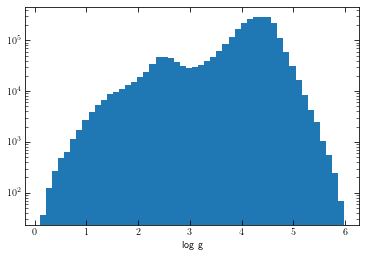

In [11]:
plt.hist(data['log_g'],bins=50,log=True)
plt.xlabel('log g');

Plotting a Kiel diagram to see how the stars fit the main sequence

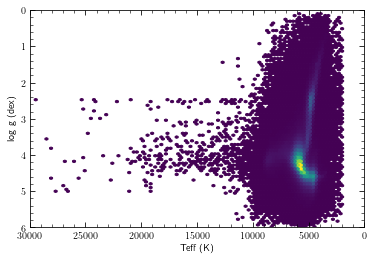

In [12]:
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(1000))
ax.yaxis.set_minor_locator(MultipleLocator(.2))

plt.hexbin(data['Teff'],data['log_g'],mincnt=1)
plt.xlim(30000,0);plt.ylim(6,0);
plt.xlabel('Teff (K)')
plt.ylabel('log g (dex)')
plt.savefig('/arc/home/aydanmckay/meetingplots/hexbindata.png')

Ah yes. there are some outliers

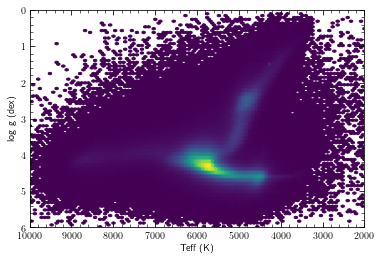

In [13]:
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_minor_locator(MultipleLocator(.2))

plt.hexbin(data['Teff'][data['Teff'] < 10000],data['log_g'][data['Teff'] < 10000],mincnt=1)
plt.xlabel('Teff (K)')
plt.ylabel('log g (dex)')
plt.xlim(10000,2000);plt.ylim(6,0);
plt.savefig('/arc/home/aydanmckay/meetingplots/hexbindatazoom.png')

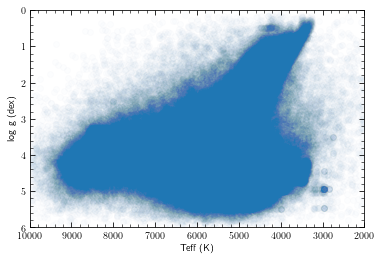

In [14]:
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_minor_locator(MultipleLocator(.2))

plt.scatter(data['Teff'][data['Teff'] < 10000],data['log_g'][data['Teff'] < 10000],alpha=0.01)
plt.xlabel('Teff (K)')
plt.ylabel('log g (dex)')
plt.xlim(10000,2000);plt.ylim(6,0);

Plotting a 2D histogram where there must be over 100 stars in the 2D bin for it to be coloured.

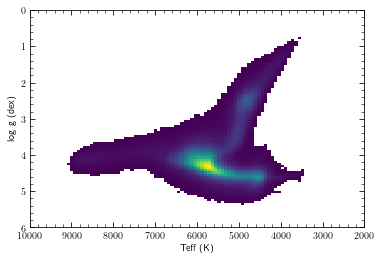

In [8]:
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_minor_locator(MultipleLocator(.2))

h = plt.hist2d(data['Teff'][data['Teff'] < 10000],data['log_g'][data['Teff'] < 10000],bins=100,cmin=100)
plt.xlabel('Teff (K)')
plt.ylabel('log g (dex)')
plt.xlim(10000,2000);plt.ylim(6,0);

This looks a lot more like what we are looking for.

cutting the data according to this histogram mapping.

In [9]:
data['log_g'][(data['Teff'] > 10000) | (data['Fe/H'] > 1)] *= np.nan
data['Teff'][(data['Teff'] > 10000) | (data['Fe/H'] > 1)] *= np.nan
for i in range(len(h[0][0])):
    for j in range(len(h[0][0])):
        if np.isnan(h[0][i][j]) or h[0][i][j] == 1.:
            data[(data['Teff'] >= h[1][i]) & (data['Teff'] <= h[1][i+1]) & (data['log_g'] >= h[2][j]) & (data['log_g'] <= h[2][j+1])] *= np.nan
            # continue
        # print(i,j)
    print(i)

/tmp/ipykernel_8575/2190903923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_g'][(data['Teff'] > 10000) | (data['Fe/H'] > 1)] *= np.nan
/tmp/ipykernel_8575/2190903923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Teff'][(data['Teff'] > 10000) | (data['Fe/H'] > 1)] *= np.nan


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [10]:
data.describe()

,Source,Teff,Fe/H,log_g,bp_1,bp_2,bp_3,bp_4,bp_5,bp_6,...,rpe_46,rpe_47,rpe_48,rpe_49,rpe_50,rpe_51,rpe_52,rpe_53,rpe_54,rpe_55
count,2.683840e+06,2.679451e+06,2.683840e+06,2.679451e+06,2.683840e+06,2.683840e+06,2.683840e+06,2.683840e+06,2.683840e+06,2.683840e+06,...,2.683840e+06,2.683840e+06,2.683840e+06,2.683840e+06,2.683840e+06,2.683840e+06,2.683840e+06,2.683840e+06,2.683840e+06,2.683840e+06
mean,1.351447e+18,5.545995e+03,-2.988681e-01,3.969978e+00,3.112932e+03,-3.182217e+02,-4.740089e+01,1.068057e+01,-1.486721e+01,-5.345034e-01,...,5.497478e-01,4.603643e-01,4.628692e-01,4.229057e-01,4.219185e-01,3.765237e-01,3.258973e-01,2.926551e-01,1.211423e-01,6.290460e-02
std,1.371806e+18,8.168629e+02,3.862673e-01,7.550443e-01,3.765061e+03,6.740372e+02,1.293497e+02,4.478749e+01,2.862364e+01,3.370372e+01,...,3.711189e-01,3.329451e-01,3.140626e-01,2.853944e-01,2.815891e-01,2.576868e-01,2.335276e-01,2.110364e-01,8.119089e-02,4.373023e-02
min,1.275606e+12,3.439595e+03,-4.487347e+00,7.490956e-01,2.832256e-01,-1.158789e+04,-1.718666e+03,-1.150163e+03,-3.607251e+02,-4.856790e+02,...,7.365149e-02,7.936749e-02,5.036612e-02,5.157712e-02,5.979707e-02,4.697054e-02,4.695595e-02,4.460493e-02,2.037394e-02,1.122545e-02
25%,3.638671e+17,4.949742e+03,-4.744484e-01,3.777519e+00,5.164913e+02,-4.220798e+02,-6.204254e+01,-1.796627e+00,-2.129137e+01,-8.514448e+00,...,2.867217e-01,2.419160e-01,2.273033e-01,2.111712e-01,2.201026e-01,1.867448e-01,1.656780e-01,1.501088e-01,7.012963e-02,3.779216e-02
50%,8.514313e+17,5.540499e+03,-2.438425e-01,4.190000e+00,1.584427e+03,-9.570973e+01,-1.537938e+01,3.421474e+00,-6.431626e+00,-9.653815e-01,...,4.330648e-01,3.610860e-01,3.725370e-01,3.374272e-01,3.354422e-01,3.015657e-01,2.573699e-01,2.303851e-01,9.566024e-02,4.959963e-02
75%,1.886534e+18,5.960340e+03,-5.883978e-02,4.468600e+00,4.210752e+03,-6.147861e+00,-4.905543e-01,1.895680e+01,-1.073139e+00,5.849332e+00,...,6.992447e-01,5.738654e-01,6.103693e-01,5.522762e-01,5.391609e-01,4.917614e-01,4.139690e-01,3.690751e-01,1.453688e-01,7.342412e-02
max,6.917529e+18,9.115372e+03,4.591588e+00,5.392057e+00,3.692985e+04,5.510930e+03,2.594202e+03,6.267605e+02,6.271200e+02,9.009338e+02,...,6.935789e+00,6.231711e+00,3.908607e+00,3.928383e+00,4.231868e+00,3.302374e+00,4.092391e+00,3.842599e+00,1.664967e+00,2.041306e+00


In [11]:
with pd.option_context('mode.use_inf_as_na', True):
    data.dropna(inplace=True)
data.shape

(2679451, 224)

creating a scatter plot of the data to make sure that it is cut properly.

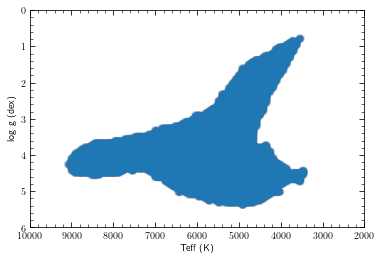

In [19]:
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_minor_locator(MultipleLocator(.2))

plt.scatter(data['Teff'],data['log_g'],alpha=0.01)
plt.xlim(10000,2000);plt.ylim(6,0);
plt.xlabel('Teff (K)')
plt.ylabel('log g (dex)')
plt.savefig('/arc/home/aydanmckay/meetingplots/scattercleandata.png')

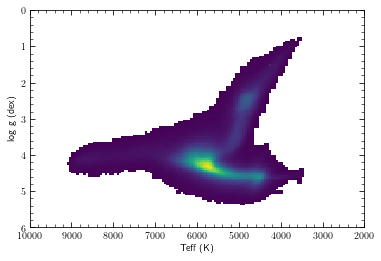

In [20]:
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_minor_locator(MultipleLocator(.2))

h = plt.hist2d(
    data['Teff'],
    data['log_g'],
    bins=100,
    cmin=1
)
plt.xlim(10000,2000);plt.ylim(6,0);
plt.xlabel('Teff (K)')
plt.ylabel('log g (dex)')
plt.savefig('/arc/home/aydanmckay/meetingplots/hist2dcleandata.png')

Full Kiel diagram of a small subset of the data

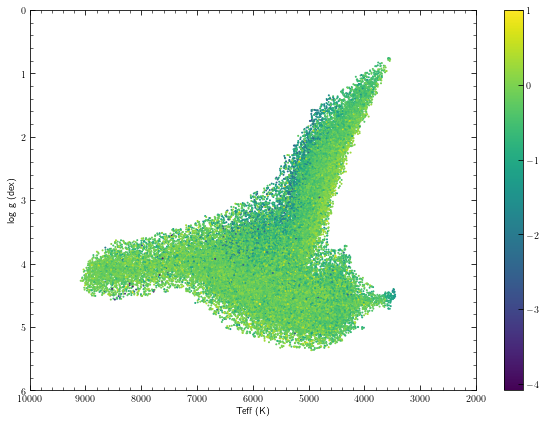

In [33]:
small = data.sample(n=100000,random_state=42)

plt.figure(figsize=(10,7))
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_minor_locator(MultipleLocator(.2))
plt.scatter(small['Teff'],small['log_g'],c=small['Fe/H'],s=1)
plt.xlim(10000,2000);plt.ylim(6,0);
plt.colorbar()
plt.xlabel('Teff (K)')
plt.ylabel('log g (dex)')
plt.savefig('/arc/home/aydanmckay/meetingplots/scattercleandatafeh.png')

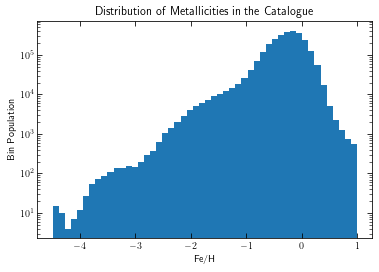

In [12]:
plt.hist(data['Fe/H'][data['Fe/H'] < 1],bins=50,log=True);
plt.xlabel('Fe/H');
plt.ylabel('Bin Population')
plt.title('Distribution of Metallicities in the Catalogue')
plt.savefig('/arc/home/aydanmckay/meetingplots/methist.png')

Saving the data to an HDF5 like how we need for the neural network, once again overwriting the designate files there are for this being everry file beginning with "prep"

In [34]:
astrotable = Table.from_pandas(data)
astrotable.write('/arc/home/aydanmckay/input_catalogue_simple_average_hugedatacuts.fits',overwrite=True)

In [22]:
feh = data['Fe/H']
teff = data['Teff']
logg = data['log_g']
xp = []
xpe = []
for elabel,label in zip(elabels,labels):
    xp.append(data[label])
    xpe.append(data[elabel])
xp = np.array(xp)
xpe = np.array(xpe)

In [23]:
xp.T.shape

(2679451, 110)

In [24]:
feh_train, feh_test, teff_train, teff_test, logg_train, logg_test, xp_train, xp_test, xpe_train, xpe_test = train_test_split(
    feh,
    teff,
    logg,
    xp.T,
    xpe.T,
    test_size=0.1,
    random_state=42
)

In [25]:
feh_train, feh_valid, teff_train, teff_valid, logg_train, logg_valid, xp_train, xp_valid, xpe_train, xpe_valid = train_test_split(
    feh_train,
    teff_train,
    logg_train,
    xp_train,
    xpe_train,
    test_size=0.1,
    random_state=42
)

In [26]:
# Create a HDF5 file
hierarchicalFileName  = "/arc/home/aydanmckay/input_catalogue_simple_average_hugedatacuts.h5"
with h5py.File(hierarchicalFileName, 'w') as hierarchicalFile:
    # Create a group under root
    train = hierarchicalFile.create_group("group_1")
    valid = hierarchicalFile.create_group("group_2")
    test = hierarchicalFile.create_group("group_3")
    
    train['data'] = np.array(
        [feh_train,
         logg_train,
         teff_train,
        ]
    )
    valid['data'] = np.array(
        [feh_valid,
         logg_valid,
         teff_valid,
        ]
    )
    test['data'] = np.array(
        [feh_test,
         logg_test,
         teff_test,
        ]
    )
    train['label'] = xp_train.T
    train['e_label'] = xpe_train.T
    valid['label'] = xp_valid.T
    valid['e_label'] = xpe_valid.T
    test['label'] = xp_test.T
    test['e_label'] = xpe_test.T

    print(hierarchicalFile["/"])
    print(train)
    print(valid)
    print(train['data'])
    print(valid["label"])
    print(test['e_label'])

<HDF5 group "/" (3 members)>
<HDF5 group "/group_1" (3 members)>
<HDF5 group "/group_2" (3 members)>
<HDF5 dataset "data": shape (3, 2170354), type "<f8">
<HDF5 dataset "label": shape (110, 241151), type "<f8">
<HDF5 dataset "e_label": shape (110, 267946), type "<f4">


In [27]:
scalerlist = [MinMaxScaler() for _ in range(110)]
with h5py.File("/arc/home/aydanmckay/input_catalogue_simple_average_hugedatacuts.h5", 'r') as f:
    d = f['group_1']['label']
    dset = d[:]
    ydat = np.array([
        scaler.fit_transform(d[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
    ])
    print(ydat.shape[1])
    print(f['group_1']['label'].shape[1])
    print(f['group_1']['data'].shape)

2170354
2170354
(3, 2170354)


In [28]:
dset.shape

(110, 2170354)

In [29]:
dset

array([[ 2.03480224e+02,  4.13543467e+03,  2.11326125e+02, ...,
         1.65722742e+03,  5.71815264e+02,  3.06489752e+03],
       [-1.50307347e+01, -3.91140275e+02,  1.35029872e+00, ...,
        -8.65396629e+01,  3.71206247e+01,  1.04023039e+02],
       [-5.44142469e+00, -1.08552758e+02, -1.02645049e+01, ...,
        -6.08033347e+01, -2.11380986e+01, -1.37335521e+02],
       ...,
       [ 2.46464065e-03,  2.70146006e-01,  9.68371504e-02, ...,
         1.88298994e-02, -6.68165205e-02,  1.38600895e-02],
       [-2.10079402e-01, -3.92802398e-01,  2.12800020e-02, ...,
         3.29285810e-01,  2.49253889e-02,  4.30699857e-02],
       [-3.07024566e-02,  8.04193878e-02, -1.46026651e-02, ...,
         4.23687289e-02,  6.70637725e-02,  1.29907266e-02]])

In [30]:
ydat

array([[0.00550229, 0.11197402, 0.00571474, ..., 0.04486769, 0.01547627,
        0.08298539],
       [0.67682211, 0.65482589, 0.67778013, ..., 0.67264001, 0.67987211,
        0.6837848 ],
       [0.42972294, 0.40385984, 0.42851319, ..., 0.41583668, 0.4257858 ,
        0.39664034],
       ...,
       [0.638671  , 0.65902591, 0.64584724, ..., 0.63991544, 0.63340276,
        0.63953753],
       [0.56747523, 0.55481008, 0.58351154, ..., 0.60486047, 0.58376421,
        0.58502188],
       [0.24666043, 0.25305223, 0.2475865 , ..., 0.25086353, 0.25228401,
        0.24917369]])